In [1]:
import argparse
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.model_selection import train_test_split
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import sys
import gc

# import setGPU
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras import backend as K
tf.keras.mixed_precision.set_global_policy('mixed_float16')

from datetime import datetime
from tensorboard import program
import os
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    import mplhep as hep
    hep.style.use(hep.style.ROOT)
    print("Using MPL HEP for ROOT style formating")
except:
    print("Instal MPL HEP for style formating")
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#DB4437", "#4285F4", "#F4B400", "#0F9D58", "purple", "goldenrod", "peru", "coral","turquoise",'gray','navy','m','darkgreen','fuchsia','steelblue']) 
from autoencoder_classes import AE,VAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from neptunecontrib.monitoring.keras import NeptuneMonitor
from losses import mse_split_loss, radius, kl_loss
from functions import make_mse_loss_numpy
from sklearn.metrics import roc_curve, auc


from data_preprocessing import prepare_data
#from model import build_AE, build_VAE, Sampling
from model import Sampling


def return_total_loss(loss, bsm_t, bsm_pred):
    total_loss = loss(bsm_t, bsm_pred.astype(np.float32))
    return total_loss

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-12GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instal MPL HEP for style formating


In [2]:
####configuration####
global input_qcd, input_bsm, events, load_pickle, input_pickle, output_pfile, \
        output_model_h5, output_model_json, output_history, output_result, \
        model_type, batch_size, n_epochs

input_qcd="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/QCD_preprocessed.h5"
input_bsm="/eos/uscms/store/group/lpctrig/jngadiub/L1TNtupleRun3-h5-extended-v2/BSM_preprocessed.h5"
events = 500000
load_pickle=False
input_pickle="data.pickle"
output_pfile="data.pickle"
output_model_h5='model.h5'
output_model_json='model.json'
output_history='history.h5'
output_result='results.h5'
model_type='VAE'
batch_size= 1024
n_epochs = 150

In [3]:
def main(hyperparameters):
    
    latent_dim = hyperparameters[:,0]
    outer_layer_width = hyperparameters[:,1]
    #outer_layer_width = 32
    #inner_layer_width = hyperparameters[:,1]
    inner_layer_width = 16
    
    
    def build_AE(input_shape,latent_dim, outer_layer_width, inner_layer_width):
        inputArray = Input(shape=(input_shape))
        x = BatchNormalization()(inputArray)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        encoder = Dense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform())(x)
        # x = BatchNormalization()(x)
        # encoder = LeakyReLU(alpha=0.3)(x)
        #decoder
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(encoder)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        decoder = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform())(x)

        #create autoencoder
        autoencoder = Model(inputs = inputArray, outputs=decoder)
        autoencoder.summary()
        # ae = AE(autoencoder)
        # ae.compile(optimizer=keras.optimizers.Adam(lr=0.00001))

        return autoencoder
    
    def build_VAE(input_shape, latent_dim, outer_layer_width, inner_layer_width):
    
        #encoder
        inputArray = Input(shape=(input_shape))
        x = BatchNormalization()(inputArray)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        mu = Dense(latent_dim, name = 'latent_mu', kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        logvar = Dense(latent_dim, name = 'latent_logvar', kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)

        # Use reparameterization trick to ensure correct gradient
        z = Sampling()([mu, logvar])

        # Create encoder
        encoder = Model(inputArray, [mu, logvar, z], name='encoder')
        encoder.summary()

        #decoder
        d_input = Input(shape=(int(latent_dim),), name='decoder_input')
        x = Dense(inner_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(d_input)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dense(outer_layer_width, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        dec = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform(seed=42))(x)

        # Create decoder 
        decoder = Model(d_input, dec, name='decoder')
        decoder.summary()
    
        # vae = VAE(encoder, decoder)
        # vae.compile(optimizer=keras.optimizers.Adam())

        return encoder,decoder
    
    if(load_pickle):
        if(input_pickle==''):
            print('Please provide input pickle files')
        with open(input_pickle, 'rb') as f:
            X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = pickle.load(f)
            bsm_labels=['VectorZPrimeToQQ__M50',
                  'VectorZPrimeToQQ__M100',
                  'VectorZPrimeToQQ__M200',
                  'VBF_HToInvisible_M125',
                  'VBF_HToInvisible_M125_private',
                  'ZprimeToZH_MZprime1000',
                  'ZprimeToZH_MZprime800',
                  'ZprimeToZH_MZprime600',
                  'GluGluToHHTo4B',
                  'HTo2LongLivedTo4mu_1000',
                  'HTo2LongLivedTo4mu_125_12',
                  'HTo2LongLivedTo4mu_125_25',
                  'HTo2LongLivedTo4mu_125_50',
                  'VBFHToTauTau',
                  'VBF_HH']
    else:
        if(input_qcd==''or input_bsm==''):
            print('Please provide input H5 files')
        X_train_flatten, X_train_scaled, X_test_flatten, X_test_scaled, bsm_data, bsm_target, pt_scaler, bsm_labels = prepare_data(input_qcd, input_bsm, events, output_pfile,True)
        
    if(model_type=='AE'):
        autoencoder = build_AE(X_train_flatten.shape[-1], latent_dim, outer_layer_width, inner_layer_width)
        model = AE(autoencoder)
        model.compile(optimizer=keras.optimizers.Adam(lr=0.001))

        callbacks=[]
        callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
        callbacks.append(TerminateOnNaN())
        callbacks.append(NeptuneMonitor())
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

    elif(model_type=='VAE'):
        encoder, decoder = build_VAE(X_train_flatten.shape[-1], latent_dim, outer_layer_width, inner_layer_width)
        model = VAE(encoder, decoder)
        model.compile(optimizer=keras.optimizers.Adam())

        callbacks=[]
        callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
        callbacks.append(TerminateOnNaN())
        callbacks.append(NeptuneMonitor())
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

    history = model.fit(X_train_flatten, X_train_scaled,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=callbacks)

    del X_train_flatten, X_train_scaled


    gc.collect()
    
    if(output_model_h5!=''):
        if(model_type=='VAE'):
            model.save(os.path.join(os.getcwd(),output_model_h5.split('.')[0]))
        else:
            model_json = autoencoder.to_json()
            with open(output_model_json, 'w') as json_file:
                json_file.write(model_json)
            autoencoder.save_weights(output_model_h5)


    if(output_history!=''):
        with open(output_history, 'wb') as f:
            pickle.dump(history.history, f)
    
    #load model
    model_dir = output_model_h5.split('.')[0]
    if(model_type=='AE'):
        with open(model_dir+"/model.json", 'r') as jsonfile: config = jsonfile.read()
        ae = tf.keras.models.model_from_json(config)    
        ae.load_weights(model_dir+"/model.h5")
        ae.summary()
        model = AE(ae)
    elif(model_type=='VAE'):
        encoder, decoder = VAE.load(model_dir, custom_objects={'Sampling': Sampling})
        encoder.summary()
        decoder.summary()
        model = VAE(encoder, decoder)
    
    from end2end import get_results
    data_file = input_pickle
    outdir = output_model_h5.split('.')[0]
    if not load_pickle: data_file = output_pfile
    results = get_results(input_qcd,input_bsm,data_file,outdir,events,model_type,latent_dim)   
    
    for key in results.keys():
        results[key]['loss'] = results[key]['loss'][np.isfinite(results[key]['loss'])]
        results[key]['total_loss'] = results[key]['total_loss'][np.isfinite(results[key]['total_loss'])]
        results[key]['radius'] = results[key]['radius'][np.isfinite(results[key]['radius'])]

    signal_eff={}

    for key in results.keys():
        if key=='QCD': continue
        signal_eff[key]={}
        true_label = np.concatenate(( np.ones(results[key]['loss'].shape[0]), np.zeros(results['QCD']['loss'].shape[0]) ))
        pred_loss = np.concatenate(( results[key]['loss'], results['QCD']['loss'] ))
        fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
        signal_eff[key]['MSE_loss']=tpr_loss[fpr_loss<0.000125][-1]

        auc_loss = auc(fpr_loss, tpr_loss)

    if(model_type=='VAE'):
        #plt.figure(figsize=(10,10))
        for key in results.keys():
            if key=='QCD': continue

            true_label = np.concatenate(( np.ones(results[key]['total_loss'].shape[0]), np.zeros(results['QCD']['total_loss'].shape[0]) ))
            pred_loss = np.concatenate(( results[key]['total_loss'], results['QCD']['total_loss'] ))
            fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
            signal_eff[key]['KL_loss']=tpr_loss[fpr_loss<0.000125][-1]

            auc_loss = auc(fpr_loss, tpr_loss)
  
        for key in results.keys():
            if key=='QCD': continue

            true_label = np.concatenate(( np.ones(results[key]['radius'].shape[0]), np.zeros(results['QCD']['radius'].shape[0]) ))
            pred_loss = np.concatenate(( results[key]['radius'], results['QCD']['radius'] ))
            fpr_loss, tpr_loss, threshold_loss = roc_curve(true_label, pred_loss)
            signal_eff[key]['radius']=tpr_loss[fpr_loss<0.000125][-1]
        
        
            auc_loss = auc(fpr_loss, tpr_loss)
    
    signal_eff_pd = pd.DataFrame.from_dict(signal_eff).transpose()

    #return auc_loss
    return -(tpr_loss[fpr_loss<0.000125][-1])

In [4]:
%matplotlib inline  
import GPy
import GPyOpt
from numpy.random import seed

bounds = [{'name': 'latent_dim', 'type': 'discrete', 'domain':(2, 3, 4, 5, 6, 7, 8)},
          {'name': 'layer_width', 'type': 'discrete', 'domain':(8, 16, 32)},]

max_iter = 30
myProblem = GPyOpt.methods.BayesianOptimization(main, domain=bounds)
myProblem.run_optimization(max_iter)

*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data


2022-04-28 14:55:15.755015: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 14:55:21.088532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1579 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 57)          228         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 16)           928         ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 16)          64          ['dense[0][0]']            

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 57)          228         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 16)           928         ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 16)          64          ['dense[0][0]']            

Epoch 1/150
196/196 [==============================] - 7s 7ms/step - loss: inf - reconstruction_loss: 0.5832 - kl_loss: inf - val_loss: nan - val_reconstruction_loss: nan - val_kl_loss: inf - lr: 0.0010
saving model to /uscms_data/d3/tphan/l1_anomaly_ae/dnn/model
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 57)          228         ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)          

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 57)          228         ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_10 (Dense)               (None, 8)            464         ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 8)           32          ['dense_10[0][0]']         

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 3)]               0         
                                                                 
 dense_17 (Dense)            (None, 16)                64        
                                                                 
 batch_normalization_18 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 batch_normalization_19 (Bat  (None, 16)               64        
 chNormalization)                                          

Epoch 29/150
196/196 [==============================] - 3s 16ms/step - loss: 0.2816 - reconstruction_loss: 0.2827 - kl_loss: 1.2518e-04 - val_loss: 0.2814 - val_reconstruction_loss: 0.2813 - val_kl_loss: 1.2085e-04 - lr: 1.0000e-05
Epoch 30/150
196/196 [==============================] - 4s 20ms/step - loss: 0.2833 - reconstruction_loss: 0.2826 - kl_loss: 1.2622e-04 - val_loss: 0.2814 - val_reconstruction_loss: 0.2813 - val_kl_loss: 1.2362e-04 - lr: 1.0000e-05
Epoch 31/150
194/196 [============================>.] - ETA: 0s - loss: 0.2824 - reconstruction_loss: 0.2827 - kl_loss: 1.2671e-04
Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
196/196 [==============================] - 3s 15ms/step - loss: 0.2824 - reconstruction_loss: 0.2826 - kl_loss: 1.2667e-04 - val_loss: 0.2814 - val_reconstruction_loss: 0.2813 - val_kl_loss: 1.2186e-04 - lr: 1.0000e-05
Epoch 32/150
196/196 [==============================] - 3s 13ms/step - loss: 0.2837 - reconstruction_loss

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_15 (BatchN  (None, 57)          228         ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_15 (Dense)               (None, 16)           928         ['batch_normalization_15[0][0]'] 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 16)          64          ['dense_15[0][0]']         

Epoch 1/150
196/196 [==============================] - 13s 26ms/step - loss: 0.9748 - reconstruction_loss: 0.4537 - kl_loss: 0.2307 - val_loss: 0.3991 - val_reconstruction_loss: 0.3383 - val_kl_loss: 0.0609 - lr: 0.0010
Epoch 2/150
196/196 [==============================] - 4s 18ms/step - loss: 0.3446 - reconstruction_loss: 0.3058 - kl_loss: 0.0182 - val_loss: 0.3135 - val_reconstruction_loss: 0.3019 - val_kl_loss: 0.0117 - lr: 0.0010
Epoch 3/150
196/196 [==============================] - 4s 21ms/step - loss: 0.2995 - reconstruction_loss: 0.2920 - kl_loss: 0.0065 - val_loss: 0.3017 - val_reconstruction_loss: 0.2963 - val_kl_loss: 0.0054 - lr: 0.0010
Epoch 4/150
196/196 [==============================] - 3s 17ms/step - loss: 0.2988 - reconstruction_loss: 0.2894 - kl_loss: 0.0035 - val_loss: 0.2974 - val_reconstruction_loss: 0.2943 - val_kl_loss: 0.0032 - lr: 0.0010
Epoch 5/150
196/196 [==============================] - 3s 17ms/step - loss: 0.2945 - reconstruction_loss: 0.2881 - kl_loss:

Epoch 34/150
196/196 [==============================] - 3s 17ms/step - loss: 0.2850 - reconstruction_loss: 0.2845 - kl_loss: 5.0248e-04 - val_loss: 0.2866 - val_reconstruction_loss: 0.2855 - val_kl_loss: 0.0012 - lr: 1.0000e-06
Epoch 35/150
196/196 [==============================] - 3s 16ms/step - loss: 0.2831 - reconstruction_loss: 0.2845 - kl_loss: 5.1888e-04 - val_loss: 0.2872 - val_reconstruction_loss: 0.2863 - val_kl_loss: 9.7620e-04 - lr: 1.0000e-06
Epoch 36/150
196/196 [==============================] - 3s 16ms/step - loss: 0.2871 - reconstruction_loss: 0.2845 - kl_loss: 5.0770e-04 - val_loss: 0.2866 - val_reconstruction_loss: 0.2854 - val_kl_loss: 0.0013 - lr: 1.0000e-06
Epoch 37/150
196/196 [==============================] - 3s 13ms/step - loss: 0.2829 - reconstruction_loss: 0.2846 - kl_loss: 5.0765e-04 - val_loss: 0.2872 - val_reconstruction_loss: 0.2862 - val_kl_loss: 0.0011 - lr: 1.0000e-06
Epoch 38/150
196/196 [==============================] - 3s 17ms/step - loss: 0.2851 

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_20 (BatchN  (None, 57)          228         ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_20 (Dense)               (None, 8)            464         ['batch_normalization_20[0][0]'] 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 8)           32          ['dense_20[0][0]']         

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 7)]               0         
                                                                 
 dense_27 (Dense)            (None, 16)                128       
                                                                 
 batch_normalization_28 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 8)                 136       
                                                                 
 batch_normalization_29 (Bat  (None, 8)                32        
 chNormalization)                                          

*** OutputFile Created
*** Reading QCD
QCD: (500000, 19, 3)
GluGluToHHTo4B : (50000, 19, 3)
HTo2LongLivedTo4mu_1000 : (39851, 19, 3)
HTo2LongLivedTo4mu_125_12 : (40000, 19, 3)
HTo2LongLivedTo4mu_125_25 : (13000, 19, 3)
HTo2LongLivedTo4mu_125_50 : (40000, 19, 3)
VBFHToTauTau : (300000, 19, 3)
VBF_HH : (30000, 19, 3)
VBF_HToInvisible_M125 : (291000, 19, 3)
VBF_HToInvisible_M125_private : (488000, 19, 3)
VectorZPrimeToQQ__M100 : (1854, 19, 3)
VectorZPrimeToQQ__M200 : (38023, 19, 3)
VectorZPrimeToQQ__M50 : (6285, 19, 3)
ZprimeToZH_MZprime1000 : (50000, 19, 3)
ZprimeToZH_MZprime600 : (50000, 19, 3)
ZprimeToZH_MZprime800 : (50000, 19, 3)
*** Read BSM Data
Wrote data to a pickle file
returned data
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 57)]         0           []                  

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 batch_normalization_30 (BatchN  (None, 57)          228         ['input_7[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_30 (Dense)               (None, 16)           928         ['batch_normalization_30[0][0]'] 
                                                                                                  
 batch_normalization_31 (BatchN  (None, 16)          64          ['dense_30[0][0]']         

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 6)]               0         
                                                                 
 dense_37 (Dense)            (None, 16)                112       
                                                                 
 batch_normalization_38 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 16)                272       
                                                                 
 batch_normalization_39 (Bat  (None, 16)               64        
 chNormalization)                                          

196/196 [==============================] - 4s 19ms/step - loss: 0.2874 - reconstruction_loss: 0.2842 - kl_loss: 0.0014 - val_loss: 0.2861 - val_reconstruction_loss: 0.2845 - val_kl_loss: 0.0016 - lr: 1.0000e-05
Epoch 30/150
193/196 [============================>.] - ETA: 0s - loss: 0.2843 - reconstruction_loss: 0.2845 - kl_loss: 0.0014
Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
196/196 [==============================] - 3s 16ms/step - loss: 0.2843 - reconstruction_loss: 0.2844 - kl_loss: 0.0014 - val_loss: 0.2859 - val_reconstruction_loss: 0.2844 - val_kl_loss: 0.0014 - lr: 1.0000e-05
Epoch 31/150
196/196 [==============================] - 3s 17ms/step - loss: 0.2900 - reconstruction_loss: 0.2841 - kl_loss: 0.0014 - val_loss: 0.2860 - val_reconstruction_loss: 0.2845 - val_kl_loss: 0.0015 - lr: 1.0000e-06
Epoch 32/150
196/196 [==============================] - 3s 17ms/step - loss: 0.2865 - reconstruction_loss: 0.2843 - kl_loss: 0.0014 - val_loss: 0.

*** OutputFile Created


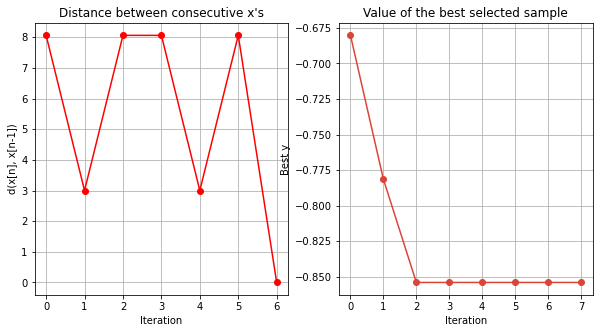

Writing evaluation results... 
   latent_dim  inner_layer_width  efficiency
0         6.0               16.0     0.68030
1         7.0                8.0     0.78144
2         4.0                8.0     0.85394
3         3.0               16.0     0.00022
4         4.0                8.0     0.00008
5         7.0                8.0     0.18220
6         6.0               16.0     0.85038
7         6.0               16.0     0.00012
The value of (latent_dim, inner_layer width) that maximizes efficiency is:[4. 8.]
The the max efficiency found is:0.85394


In [5]:
# evaluate results of optimization
myProblem.plot_convergence()
print('Writing evaluation results... ')
param1 = myProblem.get_evaluations()[0][:,0].flatten()
param2 = myProblem.get_evaluations()[0][:,1].flatten()
out = -1*myProblem.get_evaluations()[1][:].flatten()
opt_results = {'latent_dim': param1,
               'inner_layer_width': param2,
               'efficiency': out}

evals = pd.DataFrame(opt_results)
print(evals)

print('The value of (latent_dim, inner_layer width) that maximizes efficiency is:'+str(myProblem.x_opt))
print('The the max efficiency found is:'+str(-1*myProblem.fx_opt))